<a href="https://colab.research.google.com/github/gadgil-group/School_Pb_water/blob/main/NH_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import packages used in all code
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import requests
from google.colab import drive
from sklearn.neighbors import DistanceMetric
from sklearn.feature_selection import RFE
from scipy import stats
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
#import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.utils import resample
from random import seed
from random import randint
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from numpy import argmax
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import ShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
import os
import seaborn as sns
from random import sample
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from IPython.display import Image
from pydotplus import graph_from_dot_data
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn.neural_network import MLPClassifier
drive.mount('/content/drive')
import ast
import io
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score



##############################################################################################
#Preprocess data
#Dropping all irrelevant categorical columns
#use Imputer to fill in missing feature data with the mean of the column
##############################################################################################
def preprocess_data(df, Pb_threshold, normalize):
    features = df.copy()
    pd.get_dummies(features, columns=['Town'])
    features.drop(columns={ 'Alternative Facilty ID*', 'NHDES Facility ID', 
      'SAU #/Alias', 'School', 'Address', 'Town', 'lat', 'lon', 'zip code',
       'County', 'State', 'Sample ID', 'Date', 'Time',
       'Sample Location Comments', 'unsafe',  'Parameter/Analyte','Units',  'Result',
        'PWSID' }, inplace=True, axis=1)
    # 

    features = features.dropna(how='all', axis=1)

    features=features.replace({'.':np.nan})
    imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
    features = pd.DataFrame(imputer.fit_transform(features), columns = features.columns)
    labels = df['unsafe']
    imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
    features = pd.DataFrame(imputer.fit_transform(features), columns = features.columns)
    #normalize data (optional)
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(features)
        features = pd.DataFrame(x_scaled, columns = features.columns)
    return features, labels



Mounted at /content/drive


In [ ]:
#SDWIS Violations data from region 1 (NH)
#Documentation - https://www.epa.gov/enviro/web-services

url_violations = "https://data.epa.gov/efservice/VIOLATION/EPA_REGION/01/CSV"
violations_json = requests.get(url_violations).content
violations_csv = pd.read_csv(io.StringIO(violations_json.decode('utf-8')), engine='python',encoding='utf-8', error_bad_lines=False)
#Cleaning data
#Dropping inactive facilities
violations_csv.drop(violations_csv[violations_csv['PWS_ACTIVITY_CODE'] == 'I'].index, inplace=True)
violations_columns = ['PWSID', 'CONTAMINANT_CODE']
violations_csv_relevant =  pd.DataFrame(violations_csv, columns = violations_columns)


violations_csv_relevant = violations_csv_relevant.pivot_table(index='PWSID', columns='CONTAMINANT_CODE', aggfunc={'CONTAMINANT_CODE':'size'}, fill_value=0)
#Dropping all 0 columns
zero_cols = violations_csv_relevant.columns[(violations_csv_relevant == 0).all()]
violations_csv_relevant.drop(labels=zero_cols, axis=1, inplace=True)
violations_csv_relevant.columns = violations_csv_relevant.columns.droplevel(0)
violations_csv_relevant = pd.merge(violations_csv_relevant, violations_csv[['PWSID','POPULATION_SERVED_COUNT']], left_index=True, right_on='PWSID').set_index('PWSID')
#Assigning contaminant names to codes
codes = pd.read_csv('/content/drive/My Drive/data/SDWA_REF_CODE_VALUES.csv')
codes.drop(columns='VALUE_TYPE', inplace=True)
column_names = dict(zip(codes.VALUE_CODE, codes.VALUE_DESCRIPTION))
column_names['POPULATION_SERVED_COUNT']='POPULATION_SERVED_COUNT'

violations_csv_relevant.columns = [column_names[i] for i in violations_csv_relevant.columns]

<ipython-input-2-5d2d5913e7b3>:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  violations_csv = pd.read_csv(io.StringIO(violations_json.decode('utf-8')), engine='python',encoding='utf-8', error_bad_lines=False)


In [ ]:
#SDWIS PWS ZIP code data from region 2 (NH)
url_zipcode =  "https://data.epa.gov/efservice/WATER_SYSTEM/STATE_CODE/NH/CSV"
zipcode_json = requests.get(url_zipcode).content
zipcode_csv = pd.read_csv(io.StringIO(zipcode_json.decode('utf-8')), engine='python',encoding='utf-8', error_bad_lines=False, dtype={'ZIP_CODE':str})
zipcode_csv = pd.DataFrame(zipcode_csv, columns = ['PWSID', 'ZIP_CODE'])
#Largest water utility from each zip code
nh_water_utilities = pd.merge(zipcode_csv, violations_csv_relevant, how='inner', left_on='PWSID', right_on='PWSID')
nh_water_utilities.sort_values(by=['POPULATION_SERVED_COUNT'], inplace=True)
nh_water_utilities.drop_duplicates(subset=['ZIP_CODE'], keep='first', inplace=True)
nh_water_utilities.drop(columns={'Lead and Copper Rule'}, inplace=True)
nh_water_utilities['ZIP_CODE']  =nh_water_utilities['ZIP_CODE'].str.ljust(5, '0')


<ipython-input-9-92046e8525de>:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  zipcode_csv = pd.read_csv(io.StringIO(zipcode_json.decode('utf-8')), engine='python',encoding='utf-8', error_bad_lines=False, dtype={'ZIP_CODE':str})


In [ ]:
nh_water_utilities['ZIP_CODE']

611    03766
598    03247
546    03446
243    03109
39     03255
       ...  
523    03765
797    03827
525    03451
31     03574
461    03835
Name: ZIP_CODE, Length: 177, dtype: object

In [ ]:
##############################################################################################
#Add coordinates
#Add water utility data 
##############################################################################################
lats=[]
lons=[]
Pb_data = pd.read_csv("/content/drive/My Drive/data/NH dataset with census.csv", dtype={'Zip Code Tabulation Area Code':str})
Pb_data.rename(columns={'x':'lon', 'y':'lat', 'Zip Code Tabulation Area Code':'zip code'}, inplace=True)
Pb_data['zip code']  =Pb_data['zip code'].str.ljust(5, '0')
Pb_data = Pb_data.merge(nh_water_utilities, left_on='zip code', right_on= 'ZIP_CODE')
Pb_data.to_csv("/content/drive/My Drive/data/NH full dataset with utilities.csv", index=False)
Pb_data

,OBJECTID,Join_Count,TARGET_FID,NHDES Facility ID,Alternative Facilty ID*,SAU #/Alias,Facility Name,Address,Town,County,...,Radium-226,Radium-228,Gross Beta Particle Activity,ManMade Beta Particle and Photon Emitter,Tritium,38-STRONTIUM-90,Consumer Confidence Rule,Public Notice,Revised Total Coliform Rule,POPULATION_SERVED_COUNT
0,1,1,1,SCH-21335,NaN,SAU#88,HANOVER STREET SCHOOL,193 HANOVER ST.,LEBANON,GRAFTON,...,0,0,0,0,0,0,0,0,1,23
1,4,1,4,SCH-20970,SCH-27000,SAU#66,HOPKINTON HIGH SCHOOL,297 PARK AVE.,HOPKINTON,MERRIMACK,...,0,0,0,0,0,0,0,0,1,150
2,5,1,5,SCH-21430,NaN,SAU#35,WHITE MOUNTAIN SCHOOL,371 WEST FARM RD.,BETHLEHEM,GRAFTON,...,0,0,0,0,0,0,0,0,0,1750
3,6,1,6,SCH-21470,NaN,SAU#36,JEFFERSON ELEMENTARY SCHOOL,178 MEADOWS RD.,JEFFERSON,COOS,...,0,0,0,0,0,0,0,0,0,33
4,7,1,7,SCH-21735,NaN,SAU#94,WINCHESTER SCHOOL,85 PARKER ST.,WINCHESTER,CHESHIRE,...,0,0,0,0,0,0,0,0,0,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,96,1,96,CB-00619,NaN,02168-000047001000000000,OSSIPEE AREA HEAD START (MASONIC TEMPLE),535 ROUTE 25 EAST,OSSIPEE,CARROLL,...,0,0,0,0,0,0,0,0,1,126
72,97,1,97,SCH-20500,CB-06800,SAU#82,CHESTER ACADEMY,22 MURPHY DR.,CHESTER,ROCKINGHAM,...,0,0,0,0,0,0,0,1,0,25
73,98,1,98,SCH-21675,SCH-26985,SAU#92,HINSDALE HIGH SCHOOL,49 SCHOOL ST.,HINSDALE,CHESHIRE,...,0,0,0,0,0,0,1,0,0,1600
74,101,1,101,SCH-21330,NaN,SAU#75,GRANTHAM VILLAGE SCHOOL,75 LEARNING DR.,GRANTHAM,SULLIVAN,...,0,0,0,0,0,0,0,1,1,60


In [ ]:
##############################################################################################
#Closest school in each unique training set
##############################################################################################

def create_distance_matrix(data):
  dist = DistanceMetric.get_metric('euclidean')
  data['lat'] = np.radians(data['lat'].values.astype(float))
  data['lon'] = np.radians(data['lon'].values.astype(float))
  distances = pd.DataFrame(dist.pairwise(data[['lat','lon']].to_numpy())*6373,  columns=data['School'], index=data['School'])
  return distances
#Modified find closest algorithm 
def find_closest_school(full_set, x, train_set, distances): 
    x['Closest school with lead'] = np.nan
    schools_in_x = x['School'].tolist()
    schools_with_pb = full_set.loc[full_set['unsafe']==1, 'School'].tolist()
    schools_train_set_with_pb = train_set.loc[train_set['School'].isin(schools_with_pb), 'School'].tolist()
    all_schools = full_set['School'].tolist()
    distances.index = distances.columns.tolist()
    for school in schools_in_x:
        compare_schools = distances[[school]]
        compare_schools.sort_values(by = school, inplace=True)
        compare_schools['School'] = compare_schools.index.astype(str)
        compare_schools = compare_schools[compare_schools['School'].isin(schools_train_set_with_pb)]
        distance_to_school =  compare_schools.iloc[0, :][school]
        i = 1
        while distance_to_school==0:
          distance_to_school =  compare_schools.iloc[i, :][school]
          i = i+1
        x.loc[x['School']==school, 'Closest school with lead'] =distance_to_school

    return x['Closest school with lead']


In [ ]:
##############################################################################################
#Random forest model - predicts whether Pb leaching is likely to occur in a school based on 
#water quality and socio-economic datA
##############################################################################################

Pb_threshold=15
Pb_data = pd.read_csv("/content/drive/My Drive/data/NH full dataset with utilities.csv")
Pb_data=Pb_data.rename(columns={'Facility Name':'School'})
Pb_data['unsafe'] = Pb_data['Result']>Pb_threshold

distance_matrix = create_distance_matrix(Pb_data)
features_over_size={}
features, labels = preprocess_data(Pb_data, Pb_threshold, True)

#Defining the range of split sizes
sizes = np.concatenate([np.arange(0.9, 1, -0.05), np.arange(0.9, 0.1, -0.1)])
auc_scores_size=[]
f1_scores_all=[]
precision_scores_all=[]
precision_scores_errors=[]
recall_scores_all=[]
recall_scores_errors=[]
y_errors_roc=[]
y_errors_f1=[]
feature_importances=[]


##############################################################################################
#Varying split sizes
##############################################################################################
for size in sizes:
  train_features, test_features, train_labels, test_labels= train_test_split(features, 
      labels, test_size = size, random_state = 42)
  train_features.fillna(train_features.mean(), inplace=True)
  test_features.fillna(test_features.mean(), inplace=True)

  train_features_with_name = train_features.merge(Pb_data[['School']], how='left',  left_index=True, right_index=True).dropna()
  test_features_with_name = test_features.merge(Pb_data[['School']], how='left', left_index=True, right_index=True).dropna()

  test_features['Closest School Pb'] = find_closest_school(Pb_data, test_features_with_name, train_features_with_name, distance_matrix)
  train_features['Closest School Pb'] = find_closest_school(Pb_data, train_features_with_name, train_features_with_name, distance_matrix)
  rf = RandomForestClassifier(n_estimators = 1000, random_state = 42, criterion='entropy', max_depth= 20, oob_score=True, class_weight={0:1,1:100})
  rf.fit(train_features.fillna(0), train_labels)

#Define decision threshold for random forest
  threshold = 0.5

  # Predict using selected threshold
  predicted_proba = rf.predict_proba(test_features.fillna(0))
  rf_prediction = (predicted_proba [:,1] >= threshold).astype('int')
  fpr, tpr, thresholds = roc_curve(test_labels, predicted_proba[:,1])
  # get area under the curve
  roc_auc = auc(fpr, tpr)
  importances = rf.feature_importances_

  precision, recall, thresholds = precision_recall_curve(test_labels, predicted_proba[:,1])
  # average precision score
  avg_precision = average_precision_score(test_labels, predicted_proba[:,1])
  # precision auc
  pr_auc = auc(recall, precision)
  #chose best threshold based on f score
  zeros = np.where(precision == 0)
  precision = np.delete(precision, zeros)
  recall = np.delete(recall, zeros)
  thresholds= np.delete(thresholds, zeros)
  fscore = (2 * precision * recall) / (precision + recall)
  fscore = fscore[np.logical_not(np.isnan(fscore))]
  # locate the index of the largest f score
  ix = argmax(fscore)
  cv = ShuffleSplit(n_splits=10, test_size=size, random_state=42)
  rfc_cv_score = cross_val_score(rf, features, labels, cv=cv, scoring='roc_auc',  error_score='raise')
  rfc_cv_f1 = cross_val_score(rf, features, labels, cv=cv, scoring='f1')
  rfc_cv_precision = cross_val_score(rf, features, labels, cv=cv, scoring='precision',  error_score='raise')
  rfc_cv_recall = cross_val_score(rf, features, labels, cv=cv, scoring='recall',  error_score='raise')

  auc_scores_size.append(np.average(rfc_cv_score))
  f1_scores_all.append(np.average(rfc_cv_f1))
  precision_scores_all.append(np.average(rfc_cv_precision))
  recall_scores_all.append(np.average(rfc_cv_recall))

  y_errors_roc.append(stats.sem(rfc_cv_score))
  y_errors_f1.append(stats.sem(rfc_cv_f1))
  precision_scores_errors.append(stats.sem(rfc_cv_precision))
  recall_scores_errors.append(stats.sem(rfc_cv_recall))

  







Streaming output truncated to the last 5000 lines.
<ipython-input-2-a1b5295679d4>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_schools['School'] = compare_schools.index.astype(str)
<ipython-input-2-a1b5295679d4>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_schools.sort_values(by = school, inplace=True)
<ipython-input-2-a1b5295679d4>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

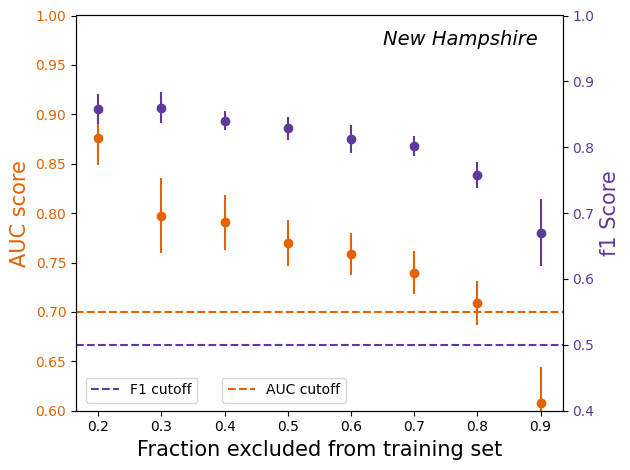

In [ ]:
##############################################################################################
#Plot changes in ROC-AUC, F1 with varying split sizes
##############################################################################################
fig, ax1 = plt.subplots()
twin1 = ax1.twinx()
#twin2.spines.set_position(("axes", 1.2))
color1 = '#E66100'




ax1.set_xlabel('Fraction excluded from training set', fontsize=15)
ax1.set_ylabel('AUC score', color=color1, fontsize=15)
ax1.errorbar(x=sizes, y=auc_scores_size, fmt='o', yerr=y_errors_roc, ecolor=color1, markerfacecolor=color1, markeredgecolor=color1)
ax1.tick_params(axis='y', labelcolor=color1,)
ax1.set_ylim(0.6, 1)
ax1.axhline(y=0.7, color=color1, linestyle='--', label='AUC cutoff')

color2 = '#5D3A9B'
twin1.set_ylabel('f1 Score', color=color2, fontsize=15)  
twin1.errorbar(x=sizes, y=f1_scores_all, fmt='o', yerr=y_errors_f1, ecolor=color2, markerfacecolor=color2, markeredgecolor=color2);
twin1.set_ylim(0.4, 1)

twin1.tick_params(axis='y', labelcolor=color2)
twin1.axhline(y=0.5, color=color2, linestyle='--', label='F1 cutoff')


fig.tight_layout()  
ax1.legend(loc=[0.3, 0.02])
twin1.legend(loc=[0.02, 0.02])

ax1.text(x=0.65, y = 0.97, s='New Hampshire',
        style ='italic',
        fontsize = 14)
plt.show()


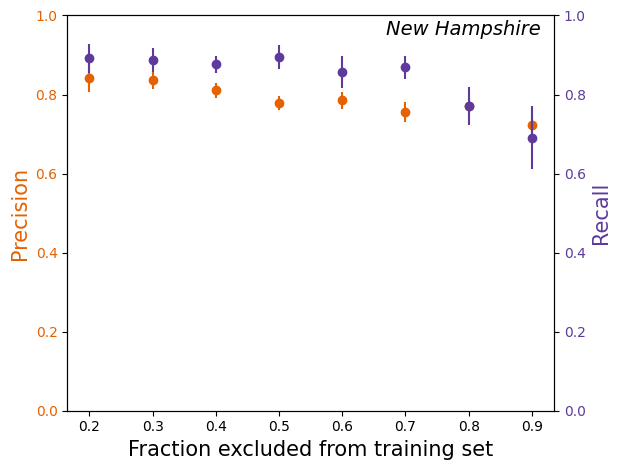

In [ ]:
fig2, ax3 = plt.subplots()

color1 ='#E66100'
ax3.set_xlabel('Fraction excluded from training set', fontsize=15)
ax3.set_ylabel('Precision', color=color1, fontsize=15)
ax3.errorbar(x=sizes, y=precision_scores_all, fmt='o', yerr=precision_scores_errors, ecolor=color1, markerfacecolor=color1, markeredgecolor=color1)
ax3.tick_params(axis='y', labelcolor=color1)
ax3.set_ylim(0, 1)
ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis

color2 =  '#5D3A9B'
ax4.set_ylabel('Recall', color=color2, fontsize=15)  # we already handled the x-label with ax1
ax4.errorbar(x=sizes, y=recall_scores_all, fmt='o', yerr=recall_scores_errors, ecolor=color2, markerfacecolor=color2, markeredgecolor=color2);

ax4.tick_params(axis='y', labelcolor=color2)

fig2.tight_layout()  # otherwise the right
ax4.set_ylim(0, 1)
ax3.text(x=0.67, y = 0.95, s='New Hampshire',
        style ='italic',
        fontsize = 14)


plt.show()

In [ ]:
##############################################################################################
#Hyperparameter optimization
##############################################################################################
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier()
X_train, X_test, y_train, y_test  = train_test_split(features, labels, test_size=0.3, random_state=1)

n_estimators = [5,20,50,100, 500, 1000, 2000] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
               n_iter =5, cv = 5, verbose=0, random_state=35, scoring='roc_auc')
rf_random.fit(X_train, y_train)
forest = RandomForestClassifier(**rf_random.best_params_) 
forest.fit( X_train, y_train) 
y_pred = forest.predict(X_test)

matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
print(classification_report(y_test, y_pred))
print(roc_auc_score( y_test, y_pred))

KeyboardInterrupt: ignored

In [ ]:
##############################################################################################
#Feature importance analysis trends over varying split size
##############################################################################################
features_plot = train_features.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

# customized number 
num_features =10
top_features = list(features_plot[i] for i in indices[-num_features:])
for feature in top_features:
  plt.plot(sizes, features_over_size[feature], label=feature)
plt.legend()

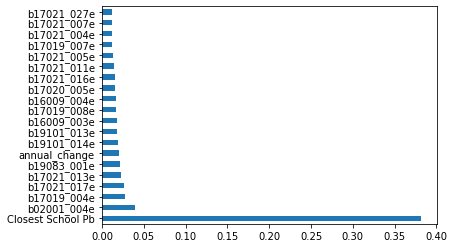

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=train_features.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
##############################################################################################
#Compare extreme split sizes for average importance
##############################################################################################
sizes=[0.2, 0.8]
Pb_threshold=15
Pb_data=Pb_data.rename(columns={'school_name':'School'})
Pb_data['unsafe'] = Pb_data['Result']>Pb_threshold
distance_matrix = create_distance_matrix(Pb_data)
features_over_size={}
features, labels = preprocess_data(Pb_data, Pb_threshold, True)
poverty_and_income = ['b17020', 'b29003', 'b29004', 'b19101', 'b19083', 'b21004', 'b17005']
race = ['b02001']
sex_based_determinants = ['b01001', 'b21004']
household_social_determinants=['b16009','b17019', 'b17021']
utilities_data = state_water_aggregate.columns
cat_feat=pd.DataFrame(columns = ['size', 'category','importance'])

#preprocess data
categories=[poverty_and_income, race, sex_based_determinants,household_social_determinants, utilities_data]
dict_categories=[poverty_and_income, race, sex_based_determinants, household_social_determinants, utilities_data, ['Closest school Pb']]
categories=[poverty_and_income, race, sex_based_determinants,household_social_determinants, utilities_data]
importances_dataframe_ny=pd.DataFrame(index=np.arange(0,6), columns = sizes)

for size in sizes:
  train_features, test_features, train_labels, test_labels= train_test_split(features, 
      labels, test_size = size, random_state = 42)

  train_features_with_name = train_features.merge(Pb_data[['School']], how='left',  left_index=True, right_index=True).dropna()
  test_features_with_name = test_features.merge(Pb_data[['School']], how='left', left_index=True, right_index=True).dropna()

  test_features['Closest School Pb'] = find_closest_school(Pb_data, test_features_with_name, train_features_with_name, distance_matrix)
  train_features['Closest School Pb'] = find_closest_school(Pb_data, train_features_with_name, train_features_with_name, distance_matrix)

  rf = RandomForestClassifier(n_estimators = 1000, random_state = 42, criterion='entropy', max_depth= 20, oob_score=True, class_weight={0:1,1:100})

  # Fit model
  rf.fit(train_features.fillna(0), train_labels)

#Define decision threshold for random forest
  threshold = 0.5

  # Predict using selected threshold
  predicted_proba = rf.predict_proba(test_features.fillna(0))
  rf_prediction = (predicted_proba [:,1] >= threshold).astype('int')
  fpr, tpr, thresholds = roc_curve(test_labels, predicted_proba[:,1])
  # get area under the curve
  roc_auc = auc(fpr, tpr)

  ##IMPORTANCES

  importances = rf.feature_importances_
  feature_lst = list(train_features.columns)
  for feature_index in np.arange(0, len(feature_lst)):
    for i in np.arange(0, len(categories)):
      if str.lower(feature_lst[feature_index][:6]) in categories[i] or feature_lst[feature_index] in categories[i]:
        new_val = importances_dataframe_ny.iloc[i, sizes.index(size)]+importances[feature_index]
        importances_dataframe_ny.iloc[i, sizes.index(size)] = new_val
        cat_feat = cat_feat.append(pd.Series({'size':size, 'category':i, 'importance':importances[feature_index]}), ignore_index=True)
      elif feature_lst[feature_index] == 'Closest School Pb':
        importances_dataframe_ny.iloc[5, sizes.index(size)] = importances[feature_index]
        cat_feat = cat_feat.append(pd.Series({'size':size, 'category':5, 'importance':importances[feature_index]}), ignore_index=True)

        break
        


Index(['NHDES Facility ID', 'Unnamed: 1', 'Alternative Facilty ID*',
       'Unnamed: 3', 'SAU #/Alias', 'School', 'Address', 'Town', 'County',
       'State',
       ...
       'Methoxychlor', 'Pentachlorophenol', 'Picloram', 'Tetrachloroethylene',
       'Toxaphene', 'Trichloroethylene', 'Vinyl chloride', 'o-Dichlorobenzene',
       'Total violations', 'unsafe'],
      dtype='object', length=231)


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_distance_metric.py:14: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  category=FutureWarning,
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators

In [ ]:
importances_dataframe_ny.to_csv("/content/drive/My Drive/data/importances_dataframe_nh.csv", index=False)


In [ ]:
cat_feat=cat_feat.groupby(['size', 'category']).agg(lambda x: np.mean(x.sort_values(ascending=False)[:5]))
cat_feat.to_csv("/content/drive/My Drive/data/nh_feature_average_df.csv", index=False)
